# Video compression

## Introduction

The purpose of this work is to implement a video codec. The following is divided in three different sections, each one corresponding to one of the lab sessions.


## TD5: Motion estimation and compensation

First of all, we load the video and extract two consecutive frames from it. 

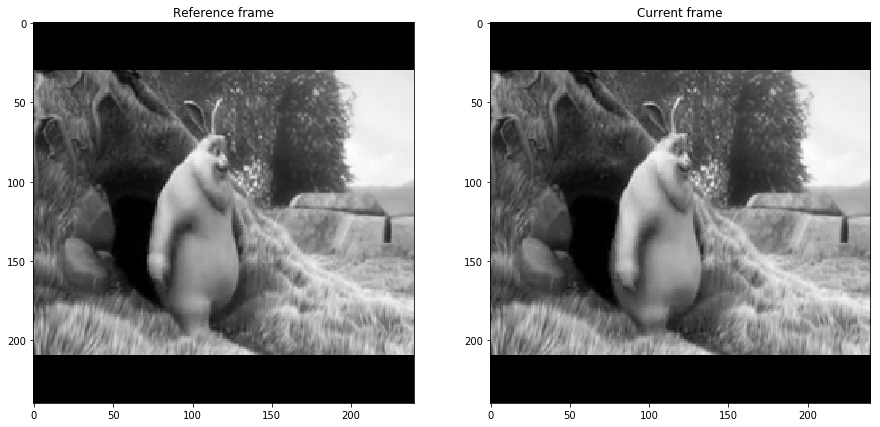

In [11]:
import math
import numpy as np
import imageio
import os
import matplotlib.pyplot as plt
from skimage import color
import td5
import imgcodec
%matplotlib inline
fig_size = [15, 15]
plt.rcParams["figure.figsize"] = fig_size

# Load the video
vid_src = "sample_video2.mp4"
vid = imageio.get_reader(vid_src, 'mp4')

# Extract two frames from the video and convert them to grayscale
# Reference Frame
fr = color.rgb2gray(vid.get_data(102))#170
# Current Frame
fc = color.rgb2gray(vid.get_data(103))#173

# Display the two frames
plt.subplot(1, 2, 1)
plt.title("Reference frame")
plt.imshow(fr)

plt.subplot(1, 2, 2)
plt.title("Current frame")
plt.imshow(fc)

plt.gray()
plt.show()

Now, it is time to run the block matching algorithm to find the motion vectors associated to each of the macroblocks in _Fc_, the current frame. Here, we use blocks of size 16x16px, and a search parameter of 8 pixels. For the sake of simplicity, the implementation of the block matching algorithm is not included here, but it can be found in the attached source code. 

The obtained motion vectors are displayed on the quiver plot below. To allow for better plot readability, they have been multiplied by 2 before representing them.

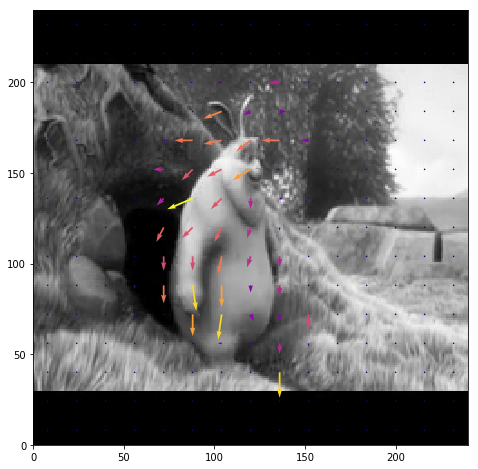

In [25]:
# Perform exhaustive search to find the motion vectors for 
# each macroblock in fr
block_size = 16
p = 8

# U, V represent the two components of the motion vectors
U, V = td5.get_motion_vectors(fr, fc, block_size, p)

height, width = fr.shape
# X, Y are the coordinates of the arrows tails
X, Y = np.meshgrid(np.arange(0+block_size/2, width, block_size),
                   np.arange(0+block_size/2, height, block_size))

# Modulo of each of the motion vectors, used to color the arrows in the quiver plot
M = np.hypot(U, np.flip(V, axis=0))

# Quiver plot, multiplying by 2 the motion vectors to make it easier to interpret
plt.imshow(fc, cmap='gray', extent=[0, width, 0, height])
plt.quiver(X, Y, np.asarray(U*2), np.asarray(np.flip(V*2, axis=0)), np.asarray(M),
           scale=1, units='xy', color="w", cmap ="plasma")

fig_size = [8, 8]
plt.rcParams["figure.figsize"] = fig_size
plt.show()

## TD6: Motion estimation and compensation

Using the previously obtained motion vectors, we can create the motion compensated frame.


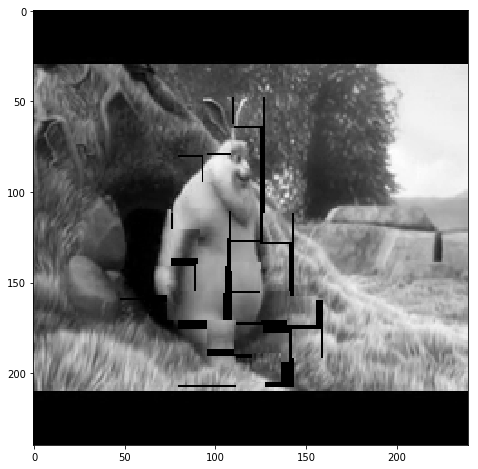

In [27]:
def motion_copy(ref, xmov, ymov, block_size):
    """Given a reference frame and the corresponding motion vectors,
    creates the motion compensated frame."""
    # Create new frame and fill it with ref
    new_frame = np.zeros_like(ref)
    #new_frame[:] = ref # TODO: Should it be like this? Or what to place in the empty spaces? 
    
    # Block by block, find where they should be
    for i in range(0, math.ceil(len(ref)/block_size)): 
        for j in range(0, math.ceil(len(ref[0])/block_size)):
            # Actual x and y coordinates on the ref matrix
            xref = i*block_size
            yref = j*block_size
            # New position will be
            x = xref + xmov[i,j]
            y = yref + ymov[i,j]
            # Update the corresponding bits in the new frame
            new_frame[x:x+block_size, y:y+block_size] = ref[xref:xref+block_size, yref:yref+block_size]

    return new_frame

# Create a new frame, fcc, placing each of the macroblocks in fr
# in the position their motion vectors indicate
fcc = motion_copy(fr, U, V, block_size)

# Display it
plt.imshow(fcc)
plt.gray()
plt.show()

As the figure above shows, the motion compensated frame is rather accurate. Due to the block matching, some empty areas are present, but overall the result is close to the actual frame.

Let us now display the difference between the current frame and the reference one, along with the difference between the current frame and the motion compensated one, denoted as _Eres_.

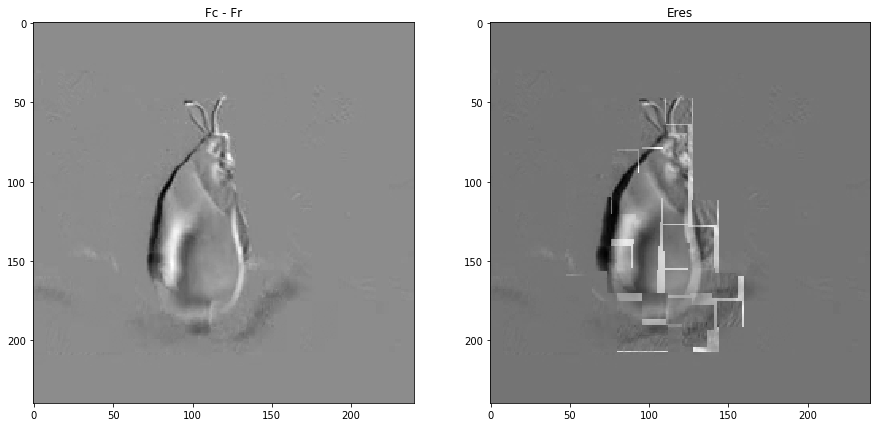

Mae = 0.0342


In [34]:
fig_size = [15, 15]
plt.rcParams["figure.figsize"] = fig_size

# Difference between fc and fr
plt.subplot(1, 2, 1)
plt.title("Fc - Fr")
plt.imshow(fc -fr)

plt.subplot(1, 2, 2)
plt.title("Eres")
eres =  fc - fcc
plt.imshow(eres)
plt.show()

# Avg motion compensated error
mae = np.absolute(eres).mean(axis = None)
print("Mae = {0:.4f}".format(mae))

As we could see from the previous results, the main problem with the motion compensated frame are the empty areas. This can be observed in the Eres, where they are the most relevant components. Apart from this, errors can also be found on the zones with the most movement. The background stayed in the same position and thus presents almost no errors.

For a more precise accuracy measure, let us calculate the mean average error and PSNR relative to this error for 20 consecutive frames of our video (we did not use the first 20 ones because the movement was very subtle in those). 

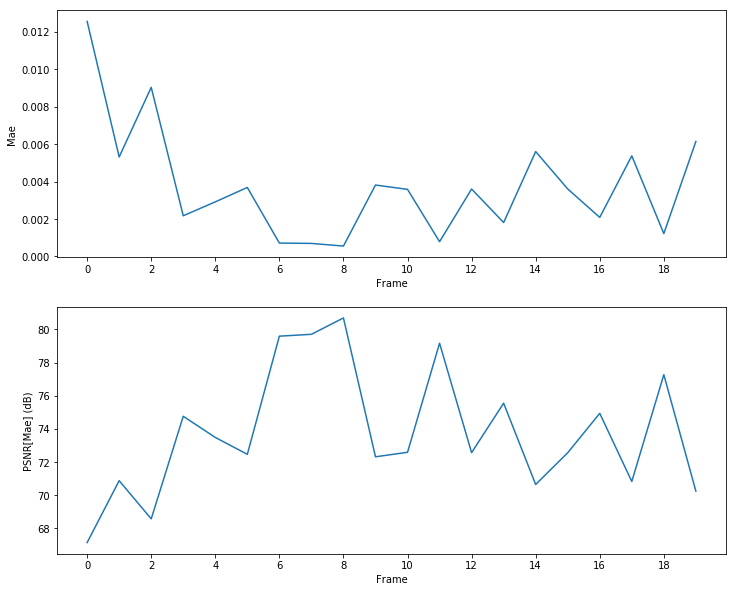

In [43]:
# Calculate mae and PSNR for the first 20 frames
mae_20  = []
psnr_20 = []

for i in range(170,190):
    # Extract the current frame and the following one
    fr = color.rgb2gray(vid.get_data(i))
    fc = color.rgb2gray(vid.get_data(i+1))

    # U, V represent the two components of the movement vectors
    U, V = td5.get_motion_vectors(fr, fc, block_size, p)

    # Create a new frame, fcc, placing each of the macroblocks in fr
    # in the position their motion vectors indicate
    fcc = motion_copy(fr, U, V, block_size)

    eres =  fc - fcc

    # Calculate mae and psnr and append to the lists
    mae = np.absolute(eres).mean(axis = None)
    mae_20.append(mae)
    psnr_20.append(10*np.log10(pow(255,2)/mae))

# Plot the results
fig_size = [12, 10]
plt.rcParams["figure.figsize"] = fig_size

plt.subplot(2, 1, 1)
plt.plot(range(len(mae_20)), mae_20)
plt.ylabel("Mae")
plt.xlabel("Frame")
plt.xticks(range(0, len(mae_20), 2))

plt.subplot(2, 1, 2)
plt.plot(range(len(psnr_20)), psnr_20)
plt.ylabel("PSNR[Mae] (dB)")
plt.xlabel("Frame")
plt.xticks(range(0, len(psnr_20), 2))
plt.show()

PSNR oscilates around 75dB, reaching a peak of just above 80dB, as well as lower values, around 65dB, for the first frames. Logically, the curve of the average motion compensated error behaves in the inverse way. Its values are within the _0.005 < Mae < 0.015_ range.



## TD 7: Video compression codec and comparison with MPEG standard

Finally, we will implement a video codec making use of the previously described steps, and compare its performance with the MPEG standard. As the whole compressing process may take some time, the sample video has been trimmed to a shorter one, spanning only 21 frames.

In order to encode the video, the first step is to compress the initial frame using a still image codec (in our case, the one we implemented in previous lab sessions). Then, we create the motion compensated frame for each of the following pairs of frames, find the associated _Eres_, compress it and store it. The video can be decoded by using the first frame and the motion vectors to reconstruct the following frames, and then correcting the predictions with help of the decoded _Eres_.  

The compressing and decompressing methods are shown below.

In [44]:
def compress_video(vid, block_size, p, R):
    """Compresses the video passed as parameter, using a given block size and search
    parameter for the block matching algorithm, and bitrate R for image compression.i
    """
    print("Compressing video...")
    all_motion = []
    all_eres = []

    first = imgcodec.compress(color.rgb2gray(vid.get_data(0)), R)

    for i in range(1, vid.get_length()):
        print("Frame {} of {}:".format(i, vid.get_length()))
        fr = color.rgb2gray(vid.get_data(i - 1))
        fc = color.rgb2gray(vid.get_data(i))

        print("Getting motion vectors...")
        # Motion compensated frame
        u, v = td5.get_motion_vectors(fr, fc, block_size, p)
        mot_comp = motion_copy(fr, u, v, block_size)

        print("Calculating and compressing Eres...")
        # Calculate the error and compress it
        eres = fc - mot_comp
        comp_eres = imgcodec.compress(eres, R)
        
        # Store eres and motion vectors
        all_eres.append(comp_eres)
        all_motion.append([u,v])

    return first, all_motion, all_eres

def decompress_video(first, motion, eres, block_size):
    """Given the first frame of a video (compressed), the motion vectors, the
    Eres (also compressed), and the block size used for the block matching algorithm,
    reconstructs the original video."""

    print("Decompressing video...")
    # Decompress the video
    frames = []

    # Decompress the first frame
    fr = imgcodec.decompress(first)
    frames.append(fr)
    for i in range(len(motion)):
        # Get the predicted frame, compensating with the error
        fc = motion_copy(fr, motion[i][0], motion[i][1], block_size)
        fc = fc + imgcodec.decompress(eres[i])
        frames.append(fc)
        # The current frame becomes the reference for next iteration 
        fr = fc
    print("Done.")
    return frames

In [ ]:
# Load the video
shortvid_src = "trimmed_sample_video2.mp4"
shortvid = imageio.get_reader(os.path.join(dirname, shortvid_src), 'mp4')
fr = color.rgb2gray(shortvid.get_data(0))

# Compress the whole video to extract the motion vectors and the error
mean_errors = []
mean_psnr = []
bitrates = []

# Lets compress the video using different bitrates 
for R in range(1, 8):
    first, motion, eres = compress_video(shortvid, block_size, p, R)

    # Reconstruct the video from what we have stored 
    reconstructed = decompress_video(first, motion, eres, block_size)


    # Find the distortion
    errors = []
    for idx,frame in enumerate(reconstructed):
        original = color.rgb2gray(shortvid.get_data(idx))
        error = original - frame
        mae = np.absolute(error).mean(axis = None)
        errors.append(mae)
    # Avg error for the whole video
    mae = sum(errors)/len(errors)
    mean_errors.append(mae)
    mean_psnr.append(10*np.log10(pow(255,2)/mae))
    
    bitrates.append(get_bitrate(shortvid, motion, R, block_size, p))

# Plot the results
plt.plot(bitrates/1000000, mean_errors)
plt.ylabel("Total average distortion")
plt.xlabel("Bitrate (Mbps)")
plt.show()

plt.plot(bitrates/1000000, mean_psnr)
plt.ylabel("PSNR")
plt.xlabel("Bitrate (Mbps)")
plt.show()    


## Appendix: Running the code

In order to